# Algorithmic Question - MultiDiGraph

## Data Structure
This solution to the algorithmic question uses a **MultiDiGraph**:
* multi - multiple edges between nodes
* di - directed

The idea is that the **poly-line** in the **3 by 3 password grid** can be represented as a **MultiDiGraph**. Each point in the password grid is a **node**, and each line that can be drawn from a point to another is an **edge**. Because only vertical and horizontal lines are allowed, this gives a graph with **9 nodes** and **24 edges**. 

![password_grid_graph](doc/q_algo_multidigraph.png)

For example, if we start from **node 0**, we can go to **node 1** or **node 3**. Additionally, each edge has a label `direction` with a single character `{'D', 'U', 'L', 'R'}` which indicates the direction that the edge is going to. For example, the edge **(0, 1)** is labeled with `direction=R`, but the edge **(1, 0)** is labelled with `direction=L`.

## Creating the Graph
As a first step, we have to create the graph. We have to add **9 nodes** and **24 edges**. Creating the edges requires to determine the neighbours of each node in the graph and which direction they should be assigned.

In [195]:
import networkx as nx
g = nx.MultiDiGraph()
g.add_nodes_from(range(9))

### Neighbours
We know that **0** should be connected to **1** and to **3**. To determine that **1** and **3** are the neighbours of **0**, we have a 3 by 3 numpy array which represents the password grid. By adding a delta of **(0, 1)** to the **row** and **column** of **0** we know that we will be moving to the right, as the **column** value is increased by 1 but the row value remains the same.

```python
0_row_col = (0, 0)
right_neighbour = 0_row_col + (0, 1) # the row and column of the neighbour to the right
```

By doing this for all 4 directions and only keeping those neighbours that are also in the grid, e.g. moving to the left of **node 0** is not possible, we end up with all of the edges that we need.

In [171]:
nodes = np.arange(9).reshape((3, 3))
valid_coords = [(x, y) for x in range(nodes.shape[0]) for y in range(nodes.shape[1])]

In [173]:
def neighbours(n, nodes):
    """Determines the neighbours of n in the nodes array.
    
    :arg
    n - the node to find neighbours for
    nodes - a numpy array.
    
    :return
    a generator with the neighbouring nodes and their directions.
    
    Example:
    list(neighbours(4, nodes))
    [(5, 'R'), (3, 'L'), (7, 'D'), (1, 'U')]
    """
    neighs = []
    row_col = np.array(np.where(nodes == n)).flatten()
    
    for delta, direction in [((0, 1), 'R'), ((0, -1), 'L'), ((1, 0), 'D'), ((-1, 0), 'U')]:
        
        new_row_col = tuple(row_col + delta)
        if new_row_col in valid_coords:
            yield nodes[new_row_col], direction

Find the neighbours for each node in the graph, and add them as edges one by one.

In [207]:
for node in g.nodes():
    for neighbour, direction in neighbours(node, nodes):
        g.add_edge(node, neighbour, direction=direction)

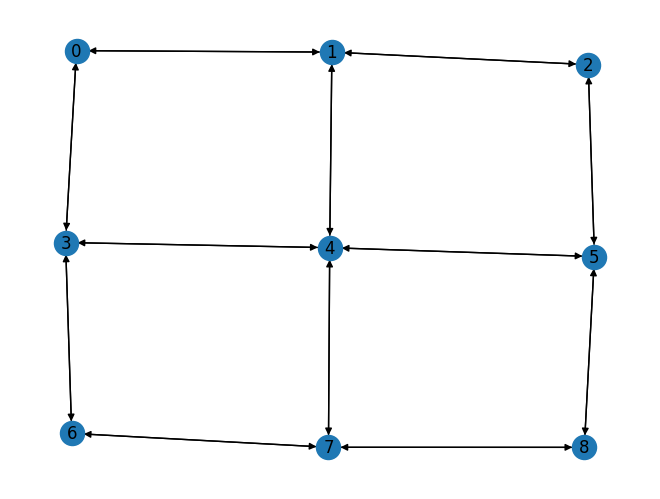

In [194]:
nx.draw(g, with_labels=True)

## Finding all direction sequences
The input is a single string that shows **just** the direction of the segment lines, i.e. **D** can mean to go down **one** node or **two** nodes. If we find **all possible sequences of directions** from the input, we can then use those to traverse the graph and see whether we manage to follow the sequence without revisiting nodes or trying to go into a direction that is not possible.

For example, the string `DRU` gives the following possible sequences:
```
['DRU', 'DRUU', 'DRRU', 'DRRUU', 'DDRU', 'DDRUU', 'DDRRU', 'DDRRUU']
```



In [196]:
def all_sequences(directions, max_steps=2):
    """Finds all possible sequences given a string of directions.
    
    :arg
    directions (str) - the directions
    max_steps (int) - determines the number of possible steps that you can take in a single direction.
    
    :return
    a generator with a single sequence.
    """
    steps = []
    for direction in directions:
        step = [(i + 1)* direction for i in range(max_steps)]
        steps.append(tuple(step))
        
    indeces = list(itertools.product(range(2), repeat=len(directions)))
    all_steps = []
    for ind in indeces:
        step = []
        for i, s in zip(ind, range(len(steps))):
            step.append(steps[s][i])
            
        yield "".join(step)

## The Algorithm
To find solutions from an input string, we need to try to walk **all possible sequences** starting from **all nodes in the graph**. If we are able to finish a walk, we increment our count by one.

In [212]:
solutions = 0

for steps in all_sequences('DRU'):
    for start in g.nodes():
        
        current_node = start
        steps_path = list(steps)
        visited = {current_node}
        
        while steps_path:
            
            step = steps_path[0]
            edge = list(filter(lambda e: e[-1] == step, g.out_edges(current_node, data='direction')))
            
            # if there is an edge to take into the next direction and we haven't visited the node on the other side of the edge
            # so far.
            if edge and edge[0][1] not in visited:
                # move to the next node
                current_node = edge[0][1]
                visited.add(current_node)
                steps_path.pop(0)
            
            else:
                # it is not possible to take the next direction or we have visited a node already, so the path is not possible
                break
        if not steps_path:
            solutions += 1
solutions

15